# Un nuevo modelo SVR

## Instrucciones
Ahora que has construido un modelo SVR, construye uno nuevo con datos frescos (prueba uno de [estos conjuntos de datos de Duke](http://www2.stat.duke.edu/~mw/ts_data_sets.html)). Anota tu trabajo en un notebook. Visualiza los datos y tu modelo, y prueba su precisión usando MAPE y gráficos apropiados. También prueba ajustando distintos hiperparámetros y valores para los pasos de tiempo.

### Acerca del conjunto de datos

[Este conjunto de datos](https://www.kaggle.com/datasets/berkeley-biosense/synchronized-brainwave-dataset/data) recopilado por la clase MIDS de la Escuela de Información de UC Berkeley comparte un conjunto de datos recopilados mediante auriculares con detección de ondas cerebrales de consumo. Este dataset Presenta dos estímulos ligeramente diferentes a dos grupos diferentes para ambos estímulos, un grupo de aproximadamente 15 personas vio los estímulos al mismo tiempo, mientras se recopilaban datos de EEG.

Los estímulos que vio cada persona están disponibles en el `session` campo de `subject-metadata.csv`. (Los sujetos que vieron el estímulo 2 abandonaron la habitación durante el estímulo 1, y viceversa).

Para cada participante, también recopilamos de forma anónima algunos otros metadatos: (1) si habían visto previamente o no el video mostrado durante el estímulo (un anuncio de Superbowl), (2) género, (3) si vieron o no íconos ocultos mostrados. durante el ejercicio de conteo de colores, y (4) el color elegido durante el ejercicio de conteo de colores. Todo esto se puede encontrar en `subject-metadata.csv`.

También recopilamos el momento (en indra_time) de todos los eventos de estímulo tanto para la sesión 1 como para la sesión 2. Estos tiempos están incluidos en `stimulus-times.csv`.

> Nota : Una calidad de señal de 0 es óptima. Los valores superiores a 128 indican que los auriculares se colocaron incorrectamente.

### Preparación y exploración de los datos

1. Para comenzar este análisis exploratorio, primero use matplotlib para importar bibliotecas y definir funciones para trazar los datos. Dependiendo de los datos, no se harán todas las parcelas. (¡Oye, solo soy un bot de kerneling, no un Gran Maestro de las Competiciones de Kaggle!)

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
print(os.listdir('../Data'))

['eeg-data.csv', 'energy.csv', 'stimulus-times.csv', 'subject-metadata.csv', 'top_six_economies.csv']


2. Las siguientes celdas de código definen funciones para trazar datos..

In [13]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if 1 < nunique[col] < 50]]  # Pick columns with unique values between 1 and 50
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))  # Ensure nGraphRow is an integer
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [18]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth, filename='DataFrame'):
    df = df.dropna(axis='columns')  # Drop columns with NaN values
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns with more than 1 unique value
    
    # Filtrar solo columnas numéricas
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({numeric_df.shape[1]}) is less than 2')
        return
    
    corr = numeric_df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [21]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    # Filtrar solo columnas numéricas
    df = df.select_dtypes(include=[np.number])
    # Eliminar filas y columnas que contengan NaN
    df = df.dropna(axis='columns')
    # Mantener columnas con más de un valor único
    df = df[[col for col in df if df[col].nunique() > 1]]
    columnNames = list(df)
    if len(columnNames) > 10:  # Reducir el número de columnas para la inversión de matriz de gráficos de densidad de kernel
        columnNames = columnNames[:10]
    df = df[columnNames]
    
    # Crear la matriz de dispersión
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(corrs, k=1)):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

Ahora está listo para leer los datos y usar las funciones de trazado para visualizar los datos.

In [9]:
nRowsRead = 1000 # especifique 'None' si desea leer todo el archivo
# eeg-data.csv puede tener más filas en realidad, pero solo estamos cargando/previsualizando las primeras 1000 filas
df1 = pd.read_csv('../Data/eeg-data.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'eeg-data.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 13 columns


In [24]:
df1.info()
df1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   id                 1000 non-null   int64 
 2   indra_time         1000 non-null   object
 3   browser_latency    1000 non-null   int64 
 4   reading_time       1000 non-null   object
 5   attention_esense   1000 non-null   int64 
 6   meditation_esense  1000 non-null   int64 
 7   eeg_power          1000 non-null   object
 8   raw_values         1000 non-null   object
 9   signal_quality     1000 non-null   int64 
 10  createdAt          1000 non-null   object
 11  updatedAt          1000 non-null   object
 12  label              1000 non-null   object
dtypes: int64(6), object(7)
memory usage: 101.7+ KB


,Unnamed: 0,id,indra_time,browser_latency,reading_time,attention_esense,meditation_esense,eeg_power,raw_values,signal_quality,createdAt,updatedAt,label
0,3730,12,2015-05-09 23:13:42.281,1461,2015-05-09 16:13:40.954,0,0,"[944412.0, 111373.0, 52404.0, 28390.0, 3237.0,...","[-203.0, -202.0, -196.0, -185.0, -163.0, -137....",200,2015-05-09 23:13:39.550,2015-05-09 23:13:39.549+00,unlabeled
1,3732,12,2015-05-09 23:13:43.186,1461,2015-05-09 16:13:41.964,0,0,"[1793049.0, 89551.0, 3896.0, 21727.0, 9301.0, ...","[104.0, 134.0, 128.0, 121.0, 145.0, 151.0, 123...",200,2015-05-09 23:13:40.559,2015-05-09 23:13:40.559+00,unlabeled
2,3734,12,2015-05-09 23:13:44.392,1461,2015-05-09 16:13:42.950,0,0,"[400192.0, 640624.0, 153087.0, 69733.0, 98854....","[2002.0, 2047.0, 2047.0, 2047.0, 2047.0, 2047....",200,2015-05-09 23:13:41.549,2015-05-09 23:13:41.549+00,unlabeled
3,3735,12,2015-05-09 23:13:45.297,1461,2015-05-09 16:13:43.935,0,0,"[681192.0, 138630.0, 67891.0, 26459.0, 592240....","[1287.0, 1241.0, 1196.0, 1155.0, 1113.0, 1072....",200,2015-05-09 23:13:42.532,2015-05-09 23:13:42.532+00,unlabeled
4,3737,12,2015-05-09 23:13:46.201,1460,2015-05-09 16:13:44.936,0,0,"[268406.0, 197772.0, 190654.0, 266433.0, 91683...","[1905.0, 1836.0, 1770.0, 1707.0, 1645.0, 1587....",200,2015-05-09 23:13:43.532,2015-05-09 23:13:43.532+00,unlabeled


#### Gráficos de distribución (histograma/gráfico de barras) de las columnas muestreadas

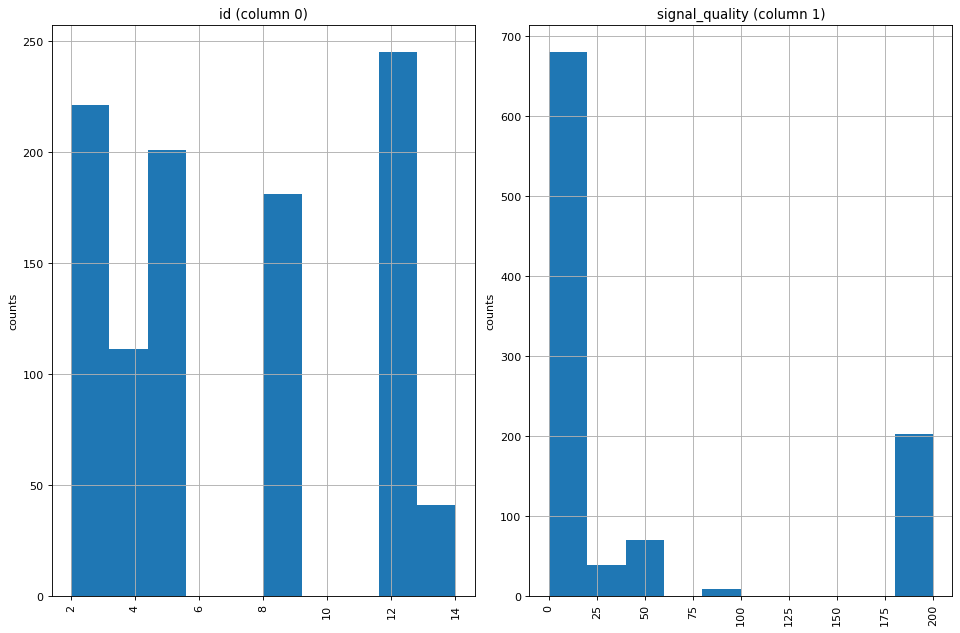

In [14]:
plotPerColumnDistribution(df1, 10, 5)

Matriz de correlación:

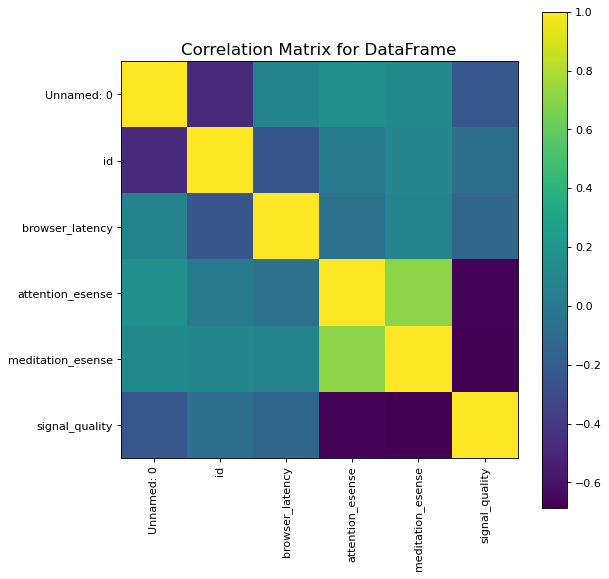

In [19]:
plotCorrelationMatrix(df1, 8)

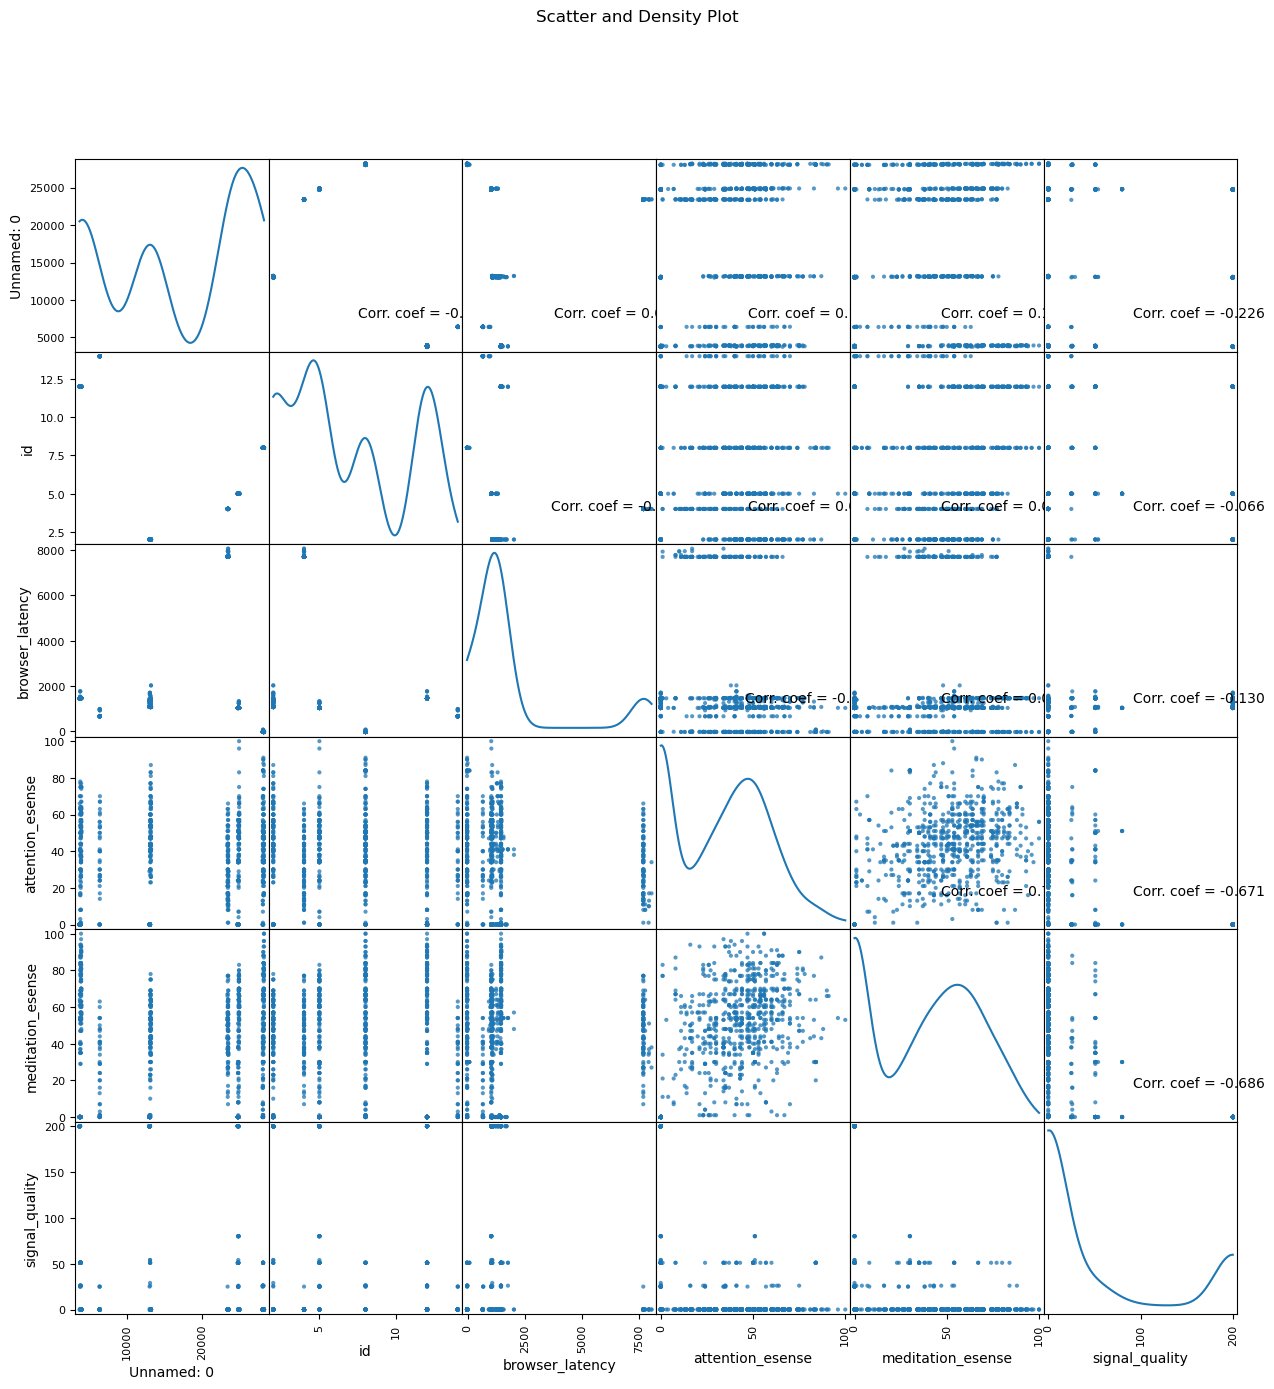

In [22]:
plotScatterMatrix(df1, 15, 10)

### Preprocesamiento de datos
1. Primero, es importante convertir las columnas de tipo object que contienen datos numéricos y las fechas a un formato adecuado.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [31]:
# Convertir columnas de fechas a datetime
df1['indra_time'] = pd.to_datetime(df1['indra_time'])
df1['reading_time'] = pd.to_datetime(df1['reading_time'])
df1['createdAt'] = pd.to_datetime(df1['createdAt'])

In [34]:
# Convertir la etiqueta a numérico si es necesario, por ejemplo:
df1['label'] = df1['label'].astype('category').cat.codes

# Seleccionar características y objetivo
features = df1[['browser_latency', 'attention_esense', 'meditation_esense', 'eeg_power', 'raw_values', 'signal_quality']]
target = df1['label']

In [37]:
# Extraer características temporales si es relevante
df1['indra_hour'] = df1['indra_time'].dt.hour
df1['reading_hour'] = df1['reading_time'].dt.hour

In [38]:
# Convertir las columnas 'eeg_power' y 'raw_values' a listas o vectores si se puede
# Aquí asumimos que están representadas como cadenas de números separados por comas
df1['eeg_power'] = df1['eeg_power'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
df1['raw_values'] = df1['raw_values'].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)

# Eliminar columnas irrelevantes
df1 = df1.drop(columns=['Unnamed: 0', 'id', 'indra_time', 'reading_time', 'createdAt', 'updatedAt'])


In [41]:
# Codificar la variable objetivo 'label'
label_encoder = LabelEncoder()
df1['label'] = label_encoder.fit_transform(df1['label'])

# Eliminar filas con valores faltantes generados en la transformación
df1 = df1.dropna()

# Separar características (X) y objetivo (y)
X = df1.drop(columns='label')
y = df1['label']

### Normalizar los Datos
Normalizamos las características numéricas para el modelo SVR.